In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [152]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.1


In [153]:
df = pd.read_csv('HealthData.csv') 
print("Data Shape:", df.shape) 
print(df.head()) 

Data Shape: (10000, 4)
           0   1          2   3
0  98.188214  80  99.749348  90
1  98.809898  74  99.346196  98
2  98.249848  78  99.631931  91
3  98.570041  77  99.523255  96
4  98.637673  72  98.974869  94


In [154]:
df.describe()

,0,1,2,3
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,97.740490,91.42520,95.243587,82.991400
std,2.182264,17.50997,3.984716,7.832807
min,94.000464,60.00000,85.003689,70.000000
25%,95.998633,76.00000,92.046497,77.000000
50%,98.077522,94.00000,96.738618,82.000000
75%,99.121507,106.00000,98.726657,89.000000
max,102.497957,120.00000,99.999741,100.000000


In [155]:
# Feature Matrix 
x_orig = df[['0','1','2']]

# Data labels 
y_orig = df['3'] 

print("Shape of Feature Matrix:", x_orig.shape) 
print("Shape Label Vector:", y_orig.shape) 


Shape of Feature Matrix: (10000, 3)
Shape Label Vector: (10000,)


In [156]:
train_dataset = df.sample(frac=0.8, random_state=5)
test_dataset = df.drop(train_dataset.index)
print(train_dataset)
print(test_dataset)

               0    1          2    3
7054  100.997209  102  91.870079   77
442    98.399373   82  99.781130   97
3954   97.772860   99  95.440646   91
2288   98.431476   99  96.207697   80
3196   98.126512   78  97.333287   92
6178   99.301808  110  92.249571   75
8351   94.493637  108  92.955934   77
5658   97.696357   68  99.076697   84
2065   98.458660   94  99.166908   87
413    98.271281   85  99.662325  100
8594   94.402643  118  92.703073   75
1805   96.771574   61  99.095883   80
3631   97.306781   84  97.498918   98
837    98.495097   89  99.811801   99
9322   94.781692  120  88.708872   72
4186   95.929821   89  98.045244   83
6568  100.239376  109  93.991647   75
5401   97.123400   68  97.511421   80
8467   94.943483  101  92.851337   78
1995   98.904768   60  97.432165   80
5153   99.373612   63  98.174681   81
4921   96.151041   71  98.989414   88
7755  102.370168  100  91.344725   77
5492   98.272437   64  98.814505   83
2593   98.846158   99  97.067255   85
1745   99.28

In [157]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('3')
test_labels = test_features.pop('3')
print(train_labels)
print(test_labels)

7054     77
442      97
3954     91
2288     80
3196     92
6178     75
8351     77
5658     84
2065     87
413     100
8594     75
1805     80
3631     98
837      99
9322     72
4186     83
6568     75
5401     80
8467     78
1995     80
5153     81
4921     88
7755     77
5492     83
2593     85
1745     87
7398     79
8046     73
3830     93
4871     89
       ... 
1974     81
3083     91
7410     79
1300     83
4492     85
4768     81
2910     88
5803     80
3739     91
5843     83
5763     79
9227     78
2776     81
5632     81
5381     85
1724     90
3108     97
8040     78
2759     90
3202     95
7053     72
4343     83
799      93
5461     77
2135     81
3519     90
6862     81
1438     80
5862     83
9209     70
Name: 3, Length: 8000, dtype: int64
3        96
10       90
18       94
25       97
35       97
36       92
37       92
41      100
43       97
44       92
48       99
63       99
66       99
71      100
78       94
81       96
85       96
90       97
92       98
107 

In [158]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
0,97.729176,2.172933
1,91.340625,17.498661
2,95.267603,3.983633
3,83.034000,7.847359


In [159]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[97.729 91.341 95.268]


In [160]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[101.   102.    91.87]]

Normalized: [[ 1.5   0.61 -0.85]]


In [161]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.predict(train_features[:10])

array([[-1.198],
       [-0.325],
       [-0.46 ],
       [-0.782],
       [ 0.321],
       [-1.132],
       [ 0.465],
       [ 0.774],
       [-0.921],
       [-0.431]], dtype=float32)

In [162]:
linear_model.layers[1].kernel

<tf.Variable 'dense_25/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.716],
       [-0.963],
       [-0.546]], dtype=float32)>

In [163]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=['Accuracy'])

In [164]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
200/200 [==============================] - 0s 2ms/step - loss: 73.0712 - accuracy: 0.0000e+00 - val_loss: 63.2002 - val_accuracy: 0.0000e+00
Epoch 2/100
200/200 [==============================] - 0s 1ms/step - loss: 53.0585 - accuracy: 0.0000e+00 - val_loss: 43.2292 - val_accuracy: 0.0000e+00
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 33.0449 - accuracy: 0.0000e+00 - val_loss: 23.3017 - val_accuracy: 0.0000e+00
Epoch 4/100
200/200 [==============================] - 0s 1ms/step - loss: 13.6452 - accuracy: 0.0000e+00 - val_loss: 5.9754 - val_accuracy: 0.0000e+00
Epoch 5/100
200/200 [==============================] - 0s 1ms/step - loss: 4.8788 - accuracy: 0.0000e+00 - val_loss: 4.8278 - val_accuracy: 0.0000e+00
Epoch 6/100
200/200 [==============================] - 0s 1ms/step - loss: 4.6676 - accuracy: 0.0000e+00 - val_loss: 4.8155 - val_accuracy: 0.0000e+00
Epoch 7/100
200/200 [==============================] - 0s 1ms/step - loss: 4.6624 - acc

Epoch 55/100
200/200 [==============================] - 0s 2ms/step - loss: 4.6684 - accuracy: 0.0000e+00 - val_loss: 4.8723 - val_accuracy: 0.0000e+00
Epoch 56/100
200/200 [==============================] - 0s 1ms/step - loss: 4.6663 - accuracy: 0.0000e+00 - val_loss: 4.8159 - val_accuracy: 0.0000e+00
Epoch 57/100
200/200 [==============================] - 0s 2ms/step - loss: 4.6702 - accuracy: 0.0000e+00 - val_loss: 4.8303 - val_accuracy: 0.0000e+00
Epoch 58/100
200/200 [==============================] - 0s 2ms/step - loss: 4.6643 - accuracy: 0.0000e+00 - val_loss: 4.8087 - val_accuracy: 0.0000e+00
Epoch 59/100
200/200 [==============================] - 0s 1ms/step - loss: 4.6773 - accuracy: 0.0000e+00 - val_loss: 4.8537 - val_accuracy: 0.0000e+00
Epoch 60/100
200/200 [==============================] - 0s 2ms/step - loss: 4.6699 - accuracy: 0.0000e+00 - val_loss: 4.8217 - val_accuracy: 0.0000e+00
Epoch 61/100
200/200 [==============================] - 0s 1ms/step - loss: 4.6686 - acc

In [165]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

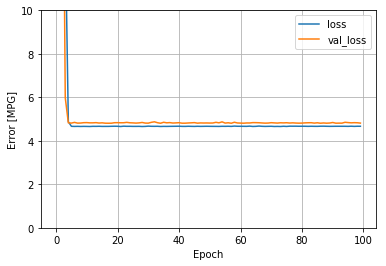

In [166]:
plot_loss(history)

In [167]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)
print(test_results)

{'linear_model': [4.608853340148926, 0.0]}


In [168]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
  return model

In [169]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [170]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 24.8 s


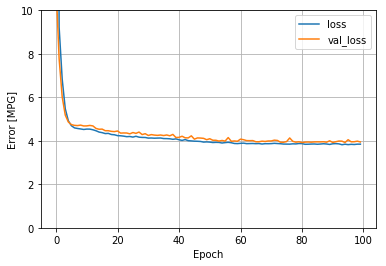

In [171]:
plot_loss(history)

In [172]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [173]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

ValueError: Shape of passed values is (2, 2), indices imply (2, 1)

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [70, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [ ]:
sns.pairplot(train_dataset[['0', '1', '2', '3']], diag_kind='kde')

In [ ]:
print(test_results)

In [ ]:
#dnn_model.save('dnn_model-v2')

In [ ]:
# reloaded = tf.keras.models.load_model('dnn_model')
# converter =tf.lite.TFLiteConverter.from_keras_model(reloaded)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()
# open("dnn_model_v1.tflite", "wb").write(tflite_model)